# Master's Thesis Analysis

Predicting discharge times of patients??

#### Author: Derek Lee

## Load Requisite Libraries and authenticate to local Postgres database

In [1]:
import pandas as pd
import psycopg2
import sqlalchemy
import time
import psutil
import numpy as np
import multiprocessing as mp

In [2]:
# Check the number of cores and memory usage
num_cores = mp.cpu_count()
print("This kernel has ",num_cores,"cores and you can find the information regarding the memory usage:",psutil.virtual_memory())

This kernel has  8 cores and you can find the information regarding the memory usage: svmem(total=17179869184, available=4673126400, percent=72.8, used=9340235776, free=178774016, active=4499181568, inactive=4387643392, wired=4841054208)


In [3]:
%reload_ext sql
from sqlalchemy import create_engine

In [4]:
import json
json_file = open("secrets.json")
variables = json.load(json_file)
json_file.close()

import os
os.environ['POSTGRES_USERNAME'] = variables['POSTGRES_USERNAME']
os.environ['POSTGRES_PASSWORD'] = variables['POSTGRES_PASSWORD']
os.environ['POSTGRES_ADDRESS'] = variables['POSTGRES_ADDRESS']
os.environ['POSTGRES_PORT'] = variables['POSTGRES_PORT']
os.environ['POSTGRES_DBNAME'] = variables['POSTGRES_DBNAME']

In [5]:
# A long string that contains the necessary Postgres login information 
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
                .format(username=os.getenv('POSTGRES_USERNAME'),
                        password=os.getenv('POSTGRES_PASSWORD'),
                        ipaddress=os.getenv('POSTGRES_ADDRESS'),
                        port=os.getenv('POSTGRES_PORT'),
                        dbname=os.getenv('POSTGRES_DBNAME'))) 
# Create the connection 
engine = create_engine(postgres_str)

-------------------------------------

### Note: Large Dataset:
Running below will take about 5 minutes because it's a dataset with approx 20 million rows

Update: cleaned the data further in sql, reducine our dataset to 3328 rows for 785 unique patients and taking 14 seconds to upload. Seems like tons of duplicate rows, which we removed to get a dataset of 3300 rows ish and 785 unique patients

In [6]:
# Use "postgres -D /usr/local/var/postgres" if the postgres database ever is shut down incorrectly therefore you can't connect


from datetime import datetime 

start_time = datetime.now() 

import time

data = pd.read_sql('''SELECT * FROM public."thesis_data";''', con=engine)


# data = pd.read_sql('''SELECT * FROM public."thesis_data";''', con=engine, chunksize=1000000)


print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

Time elapsed (hh:mm:ss.ms) 0:00:14.012989


In [8]:
from sklearn.model_selection import train_test_split

data.columns

Index(['gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag', 'row_id',
       'subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
       'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag',
       'has_chartevents_data', 'submit_wardid', 'submit_careunit',
       'curr_wardid', 'curr_careunit', 'callout_wardid', 'callout_service',
       'request_cdiff', 'request_mrsa', 'callout_status', 'callout_outcome',
       'discharge_wardid', 'acknowledge_status', 'createtime', 'updatetime',
       'acknowledgetime', 'outcometime', 'first_careunit', 'last_careunit',
       'first_wardid', 'last_wardid', 'intime', 'outtime', 'los', 'costcenter',
       'cpt_cd', 'cpt_number', 'cpt_suffix', 'sectionheader',
       'subsectionheader', 'description', 'transfertime', 'prev_service',
       'curr_service', 'seq_num', 'icd9_code'],

In [9]:
data.shape

(3328, 60)

In [10]:
data[['subject_id','intime','outtime','description', 'prev_service']].head(10)

,subject_id,intime,outtime,description,prev_service
0,160,2174-11-06 10:07:03,2174-11-07 22:37:53,None,None
1,160,2174-11-06 10:07:03,2174-11-07 22:37:53,None,None
2,160,2174-11-06 10:07:03,2174-11-07 22:37:53,None,None
3,160,2174-11-06 10:07:03,2174-11-07 22:37:53,None,None
4,160,2174-11-06 10:07:03,2174-11-07 22:37:53,None,None
5,160,2174-11-06 10:07:03,2174-11-07 22:37:53,None,None
6,160,2174-11-06 10:07:03,2174-11-07 22:37:53,None,None
7,197,2174-03-23 00:34:45,2174-03-23 20:24:29,None,None
8,197,2174-03-23 00:34:45,2174-03-23 20:24:29,"VENT MGMT, 1ST DAY (INVASIVE)",None
9,262,2153-09-25 18:02:24,2153-09-27 13:59:18,None,None


#### Creating the target variable:

Our target variable is the time it takes from when a person is ready for discharge to when they are actually discharged. This needs to be engineered from our data.

In [11]:
data['timediff'] = data['outtime']-data['intime']

In [12]:
data.timediff[0] # success!

Timedelta('1 days 12:30:50')

-----------------------------------------------------------------------

## Exploratory Data Analysis

In [13]:
data.columns

Index(['gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag', 'row_id',
       'subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
       'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag',
       'has_chartevents_data', 'submit_wardid', 'submit_careunit',
       'curr_wardid', 'curr_careunit', 'callout_wardid', 'callout_service',
       'request_cdiff', 'request_mrsa', 'callout_status', 'callout_outcome',
       'discharge_wardid', 'acknowledge_status', 'createtime', 'updatetime',
       'acknowledgetime', 'outcometime', 'first_careunit', 'last_careunit',
       'first_wardid', 'last_wardid', 'intime', 'outtime', 'los', 'costcenter',
       'cpt_cd', 'cpt_number', 'cpt_suffix', 'sectionheader',
       'subsectionheader', 'description', 'transfertime', 'prev_service',
       'curr_service', 'seq_num', 'icd9_code', 

##### Initial logic checks:

While we deduped the initial dataset, we still have lots to do to inspect and clean our data.  

1) Look to see if data makes sense. Check if there are any patients where their date of death (dod) is before date of birth (dob), is edregtime before edouttime?

2) If there are any of the times that are out of order (besides date of birth), we can flag those as administrative errors  


In [20]:
# data.gender.unique()

from datetime import datetime, timedelta 
# truth = ((data.dod.dt.date-data.dob.dt.date)<timedelta(0))
# truth = ((data.edouttime.dt.date-data.edregtime.dt.date)<timedelta(0))
# truth = ((data.updatetime.dt.date-data.createtime.dt.date)<timedelta(0))
truth = ((data.outtime.dt.date-data.intime.dt.date)<timedelta(0))
truth.unique()



array([False])

It appears that we don't have any errors with the order of times in our data. If we did, we would see some negative values in the subtraction of the two dates and therefore the array would have `True` values.  

We do have issues with the years in the `dob` and `dod` variables corresponding to date of birth and date of death. We may have to discard these as there's no better wage to ascertain age.

In [ ]:
sorted(data['dob'].unique())

##### Check for missing values

In [35]:
data['dod'].isna().sum() # 2687 people did not die within 90 days post discharge
data['dod_hosp'].isna().sum() # 3032 people did not die in hospital
data['dod_ssn'].isna().sum() # 2757 did not die according to social security records
data['language'].isna().sum() # 1042 unknown language
data['marital_status'].isna().sum() # 127 unknown marital status
data['edregtime'].isna().sum() # 2472 unknown edregtime, edouttime - likely didn't visit ED
data['submit_careunit'].isna().sum() # 3146 was not from ICU
data['discharge_wardid'].isna().sum() # 72 unknown wards to which the patient was discharged.
data['acknowledgetime'].isna().sum() # 314 did not record acknowledgetime
data['cpt_suffix'].isna().sum() # 3328 unknown Text element of the Current Procedural Terminology (CPT)
data['description'].isna().sum()# 1459 missing description of CPT
data['prev_service'].isna().sum() # 3273 missing previous service type

2687

`expire_flag`, `deathtime` will of course have some missing since it's indicating who died or not

##### Visualizing distributions of our data

**Continuous Data:** asd

**Categorical Data:** gender, 



Text(0.5, 1.0, 'Distribution of ED registration time by Day of Month')

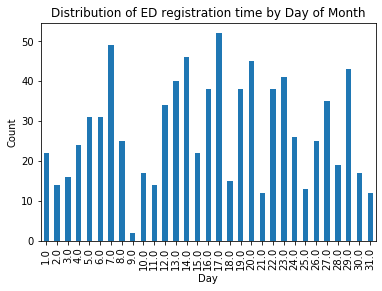

In [123]:
from scipy import stats
import matplotlib.pylab as plt

%matplotlib inline
data["edregtime"].groupby(data["edregtime"].dt.day).count().plot(kind="bar")
plt.xlabel("Day")
plt.ylabel("Count")
plt.title("Distribution of ED registration time by Day of Month")

Text(0.5, 1.0, 'Distribution of ED out time by Day of Month')

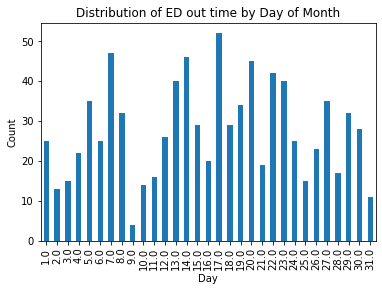

In [122]:
data["edouttime"].groupby(data["edouttime"].dt.day).count().plot(kind="bar")
plt.xlabel("Day")
plt.ylabel("Count")
plt.title("Distribution of ED out time by Day of Month")

Text(0.5, 1.0, 'Distribution of admit time by Day of Month')

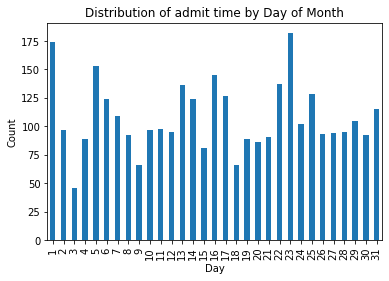

In [125]:
data["admittime"].groupby(data["admittime"].dt.day).count().plot(kind="bar")
plt.xlabel("Day")
plt.ylabel("Count")
plt.title("Distribution of admit time by Day of Month")

Text(0.5, 1.0, 'Distribution of discharge time by Day of Month')

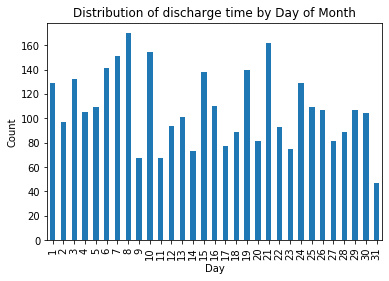

In [126]:
data["dischtime"].groupby(data["dischtime"].dt.day).count().plot(kind="bar")
plt.xlabel("Day")
plt.ylabel("Count")
plt.title("Distribution of discharge time by Day of Month")

We may want to create a new variable putting days into week in month (days 1-7, 8-14, 15-21, 22-31)

In [13]:
data.columns

Index(['gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag', 'row_id',
       'subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
       'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag',
       'has_chartevents_data', 'submit_wardid', 'submit_careunit',
       'curr_wardid', 'curr_careunit', 'callout_wardid', 'callout_service',
       'request_cdiff', 'request_mrsa', 'callout_status', 'callout_outcome',
       'discharge_wardid', 'acknowledge_status', 'createtime', 'updatetime',
       'acknowledgetime', 'outcometime', 'first_careunit', 'last_careunit',
       'first_wardid', 'last_wardid', 'intime', 'outtime', 'los', 'costcenter',
       'cpt_cd', 'cpt_number', 'cpt_suffix', 'sectionheader',
       'subsectionheader', 'description', 'transfertime', 'prev_service',
       'curr_service', 'seq_num', 'icd9_code', 

Now we want to make a correlation matrix of our data

In [100]:
data['description'].unique()

array([None, 'VENT MGMT, 1ST DAY (INVASIVE)',
       'VENT MGMT;SUBSQ DAYS(INVASIVE)', 'VENT MGMT;SUBSQ DAYS(NIV)',
       'VENT MGMT,1ST DAY (NIV)'], dtype=object)

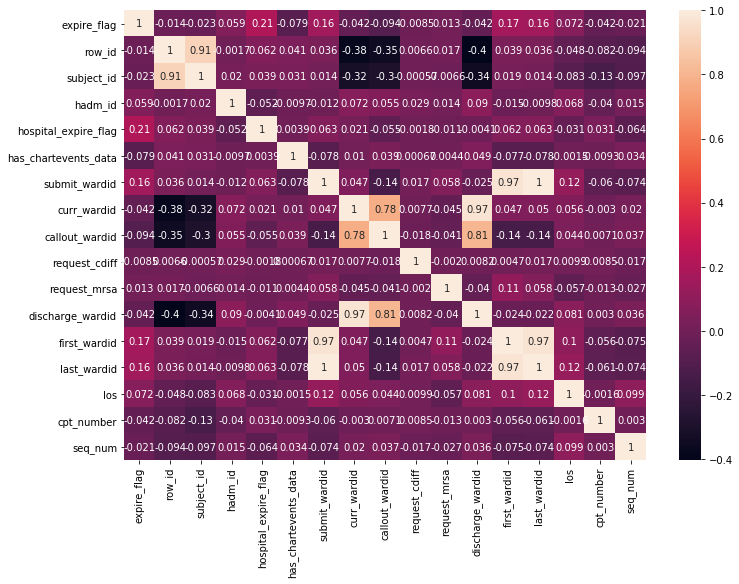

In [135]:
import seaborn as sn
a4_dims = (11.7, 8.27)
corrMatrix=data.corr()
fig, ax = plt.subplots(figsize=a4_dims)
sn.heatmap(corrMatrix,annot=True)
plt.show()